# Skin Cancer Detection using Resnet-50_fastai







Project Contributors: 18111006 (Alan Biju), 18111015 (Ayush Rai), 18111016 (Banoth Naveen Kumar), 18111025 (Gaurav Kar)

In [ ]:
import pandas as pd

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
df = pd.read_csv('/content/gdrive/My Drive/Skin_Cancer/archive/HAM10000_metadata.csv')
df.head()

lesion_id      image_id   dx dx_type   age   sex localization
0  HAM_0000118  ISIC_0027419  bkl   histo  80.0  male        scalp
1  HAM_0000118  ISIC_0025030  bkl   histo  80.0  male        scalp
2  HAM_0002730  ISIC_0026769  bkl   histo  80.0  male        scalp
3  HAM_0002730  ISIC_0025661  bkl   histo  80.0  male        scalp
4  HAM_0001466  ISIC_0031633  bkl   histo  75.0  male          ear

In [ ]:
from fastai import *
from fastai.vision import *
from fastai.callbacks.hooks import *

import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import auc,roc_curve

import os
print(os.listdir("/content/gdrive/My Drive/Skin_Cancer/archive"))

['HAM10000_metadata.csv', 'hmnist_28_28_L.csv', 'hmnist_28_28_RGB.csv', 'hmnist_8_8_RGB.csv', 'hmnist_8_8_L.csv', 'HAM10000_images_part_2', 'HAM10000_images_part_1']


## Exploratory Data Analysis

In [ ]:
# Paths and roots to the important files
path='/content/gdrive/My Drive/Skin_Cancer/archive'
csv_file='/content/gdrive/My Drive/Skin_Cancer/archive/HAM10000_metadata.csv'

In [ ]:
df=pd.read_csv(csv_file).set_index('image_id')
df.head()

lesion_id   dx dx_type   age   sex localization
image_id                                                       
ISIC_0027419  HAM_0000118  bkl   histo  80.0  male        scalp
ISIC_0025030  HAM_0000118  bkl   histo  80.0  male        scalp
ISIC_0026769  HAM_0002730  bkl   histo  80.0  male        scalp
ISIC_0025661  HAM_0002730  bkl   histo  80.0  male        scalp
ISIC_0031633  HAM_0001466  bkl   histo  75.0  male          ear

In [ ]:
# Categories of the diferent diseases
lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

In [ ]:
df.dx=df.dx.astype('category',copy=True)
df['labels']=df.dx.cat.codes # Convert the labels to numbers
df['lesion']= df.dx.map(lesion_type_dict)
df.head()

lesion_id   dx dx_type   age   sex localization  labels  \
image_id                                                                  
ISIC_0027419  HAM_0000118  bkl   histo  80.0  male        scalp       2   
ISIC_0025030  HAM_0000118  bkl   histo  80.0  male        scalp       2   
ISIC_0026769  HAM_0002730  bkl   histo  80.0  male        scalp       2   
ISIC_0025661  HAM_0002730  bkl   histo  80.0  male        scalp       2   
ISIC_0031633  HAM_0001466  bkl   histo  75.0  male          ear       2   

                         lesion  
image_id                         
ISIC_0027419  Benign keratosis   
ISIC_0025030  Benign keratosis   
ISIC_0026769  Benign keratosis   
ISIC_0025661  Benign keratosis   
ISIC_0031633  Benign keratosis

In [ ]:
print(df.lesion.value_counts())


Melanocytic nevi        6705
Melanoma                1113
Benign keratosis        1099
Basal cell carcinoma     514
Actinic keratoses        327
Vascular lesions         142
Dermatofibroma           115
Name: lesion, dtype: int64


In [ ]:
df.loc['ISIC_0027419','lesion']

'Benign keratosis '

## Countplot
Here we notice tha we have data imbalance 

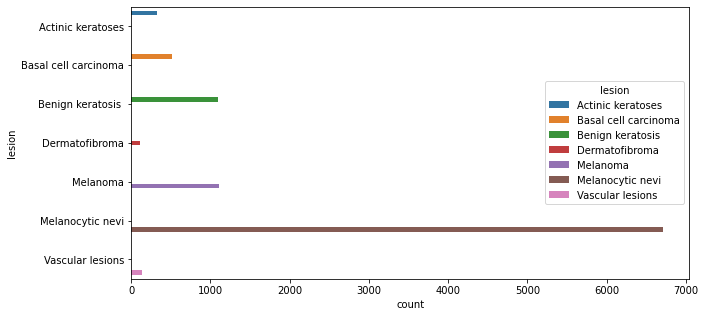

In [ ]:
fig, ax1 = plt.subplots(1, 1, figsize = (10, 5))
sns.countplot(y='lesion',data=df, hue="lesion",ax=ax1)

## Dataset

In [ ]:
class CustomImageItemList(ImageList):
    def custom_label(self,df, **kwargs)->'LabelList':
        """Custom Labels from path"""
        file_names=np.vectorize(lambda files: str(files).split('/')[-1][:-4])
        get_labels=lambda x: df.loc[x,'lesion']
        #self.items is an np array of PosixPath objects with each image path
        labels= get_labels(file_names(self.items))
        y = CategoryList(items=labels)
        res = self._label_list(x=self,y=y)
        return res

In [ ]:
def get_data(bs, size):
    train_ds = (CustomImageItemList.from_folder('/content/gdrive/My Drive/Skin_Cancer/archive', extensions='.jpg')
                    .random_split_by_pct(0.15)
                    .custom_label(df)
                    .transform(tfms=get_transforms(flip_vert=True),size=size)
                    .databunch(num_workers=2, bs=bs)
                    .normalize(imagenet_stats))
    return train_ds

In [ ]:
data=get_data(16,224)

/usr/local/lib/python3.7/dist-packages/fastai/data_block.py:217: UserWarning: `random_split_by_pct` is deprecated, please use `split_by_rand_pct`.
  warn("`random_split_by_pct` is deprecated, please use `split_by_rand_pct`.")
/usr/local/lib/python3.7/dist-packages/fastai/vision/transform.py:247: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  ../aten/src/ATen/native/BatchLinearAlgebra.cpp:766.)
  return _solve_func(B,A)[0][:,0]
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3680: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/l

In [ ]:
data.classes=list(np.unique(df.lesion))  
data.c= len(np.unique(df.lesion))  

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3680: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3680: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale

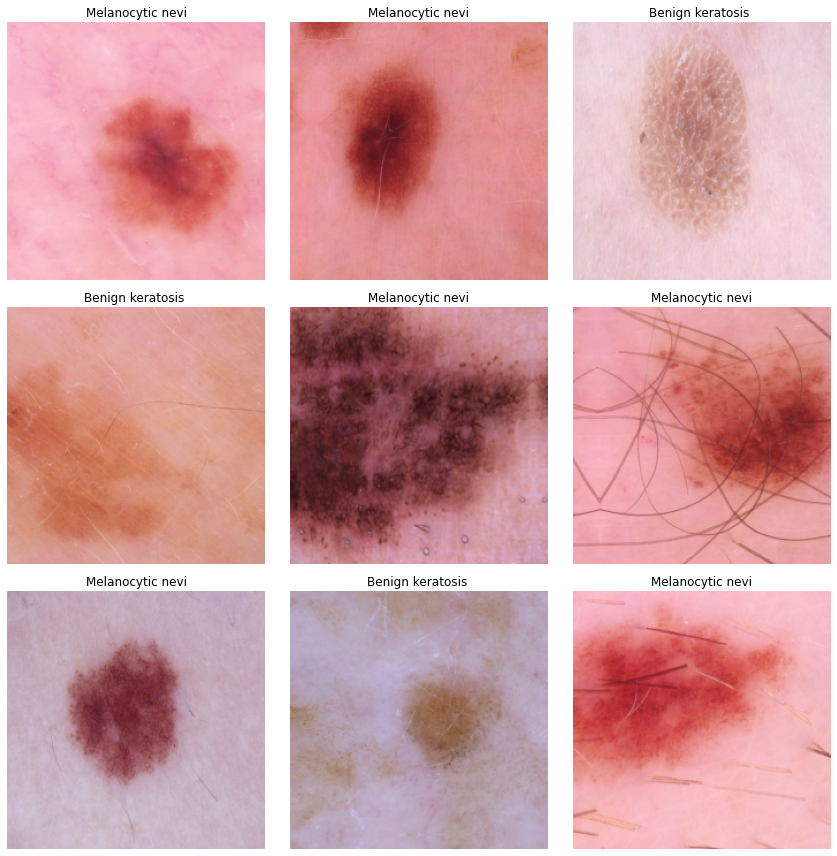

In [ ]:
data.show_batch(rows=3)

## Model ResNet50 

In [ ]:
learner=create_cnn(data,models.resnet50,metrics=[accuracy], model_dir="/tmp/model/")

/usr/local/lib/python3.7/dist-packages/fastai/vision/learner.py:109: UserWarning: `create_cnn` is deprecated and is now named `cnn_learner`.
  warn("`create_cnn` is deprecated and is now named `cnn_learner`.")
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [ ]:
learner.loss_func=nn.CrossEntropyLoss()

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3680: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3680: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


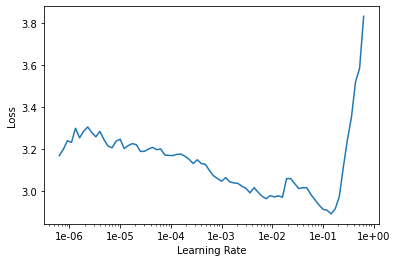

In [ ]:
learner.lr_find()
learner.recorder.plot()

In [ ]:
learner.fit_one_cycle(10, 3e-3)

Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3680: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3680: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3680: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3680: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale

KeyboardInterrupt: ignored

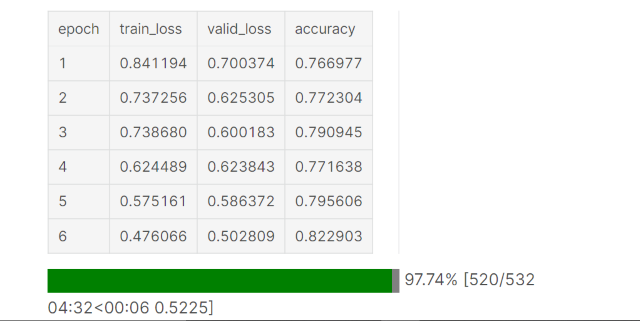

In [ ]:
learner.unfreeze()

In [ ]:
learner.lr_find()
learner.recorder.plot()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.

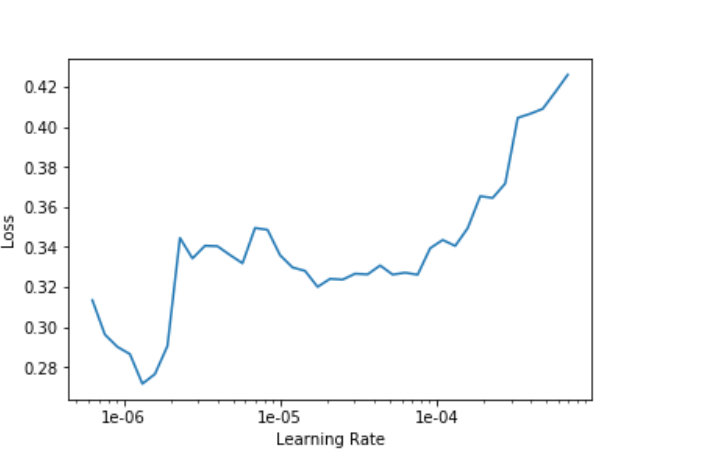

In [ ]:
lr=1e-6
learner.fit_one_cycle(3, slice(3*lr,10*lr))

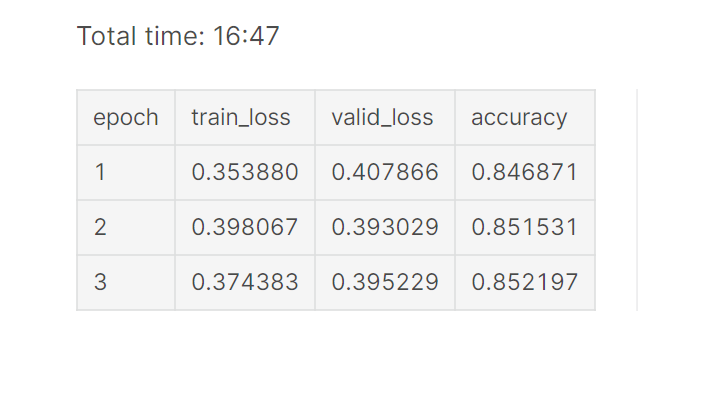

In [ ]:
learner.save('stage-1')

In [ ]:
interp = ClassificationInterpretation.from_learner(learner)

In [ ]:
interp.plot_confusion_matrix(figsize=(10,8))

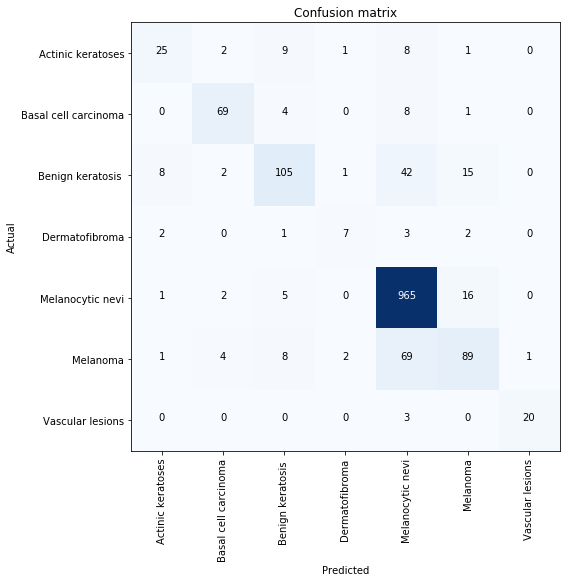

In [ ]:
interp.most_confused()

[('Melanoma', 'Melanocytic nevi', 69),
 ('Benign keratosis ', 'Melanocytic nevi', 42),
 ('Melanocytic nevi', 'Melanoma', 16),
 ('Benign keratosis ', 'Melanoma', 15),
 ('Actinic keratoses', 'Benign keratosis ', 9),
 ('Actinic keratoses', 'Melanocytic nevi', 8),
 ('Basal cell carcinoma', 'Melanocytic nevi', 8),
 ('Benign keratosis ', 'Actinic keratoses', 8),
 ('Melanoma', 'Benign keratosis ', 8),
 ('Melanocytic nevi', 'Benign keratosis ', 5),
 ('Basal cell carcinoma', 'Benign keratosis ', 4),
 ('Melanoma', 'Basal cell carcinoma', 4),
 ('Dermatofibroma', 'Melanocytic nevi', 3),
 ('Vascular lesions', 'Melanocytic nevi', 3),
 ('Actinic keratoses', 'Basal cell carcinoma', 2),
 ('Benign keratosis ', 'Basal cell carcinoma', 2),
 ('Dermatofibroma', 'Actinic keratoses', 2),
 ('Dermatofibroma', 'Melanoma', 2),
 ('Melanocytic nevi', 'Basal cell carcinoma', 2),
 ('Melanoma', 'Dermatofibroma', 2)]

## Inference

In [ ]:
pred_data=get_data(16,224)

In [ ]:
pred_data.classes=list(np.unique(df.lesion))  
pred_data.c= len(np.unique(df.lesion)) 

In [ ]:
pred_data.single_from_classes(path, pred_data.classes)

In [ ]:
predictor = create_cnn(pred_data, models.resnet50, model_dir="/tmp/model/").load('stage-1')

In [ ]:
img = open_image('../input/ham10000_images_part_2/ISIC_0029886.jpg')
img

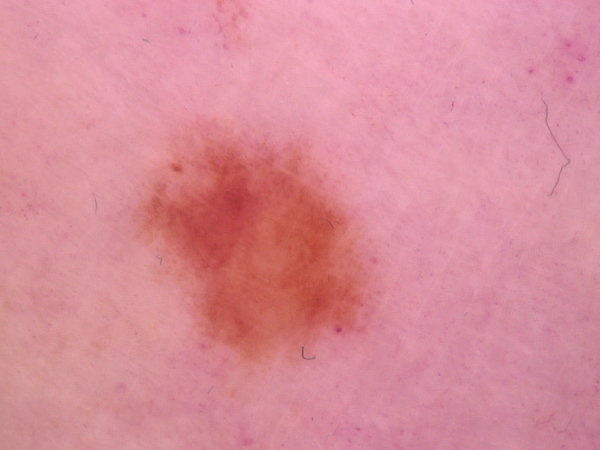

In [ ]:
pred_class,pred_idx,outputs = predictor.predict(img)
pred_class

Category Melanocytic nevi

## Predictions

In [ ]:
# Predictions of the validation data
preds_val, y_val=learner.get_preds()

### Roc Curve
With the ROC curve we will mesuare how good it's our model

In [ ]:
#  ROC curve
fpr, tpr, thresholds = roc_curve(y_val.numpy(), preds_val.numpy()[:,1], pos_label=1)

#  ROC area
pred_score = auc(fpr, tpr)
print(f'ROC area is {pred_score}')

In [ ]:
plt.figure()
plt.plot(fpr, tpr, color='orange', label='ROC curve (area = %0.2f)' % pred_score)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.01])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")

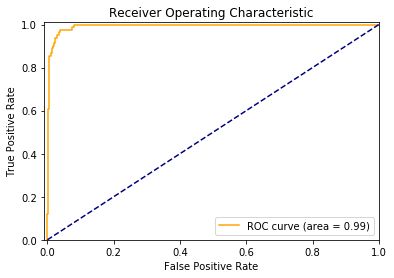

## Heatmap

In [ ]:
x,y = data.valid_ds[2]
x.show()
data.valid_ds.y[2]

Category Melanocytic nevi

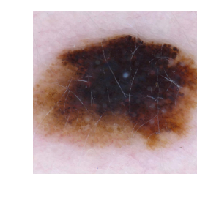

In [ ]:
def heatMap(x,y,data, learner, size=(0,224,224,0)):
    """HeatMap"""
    
    # Evaluation mode
    m=learner.model.eval()
    
    # Denormalize the image
    xb,_ = data.one_item(x)
    xb_im = Image(data.denorm(xb)[0])
    xb = xb.cuda()
    
    # hook the activations
    with hook_output(m[0]) as hook_a: 
        with hook_output(m[0], grad=True) as hook_g:
            preds = m(xb)
            preds[0,int(y)].backward()

    # Activations    
    acts=hook_a.stored[0].cpu()
    
    # Avg of the activations
    avg_acts=acts.mean(0)
    
    # Show HeatMap
    _,ax = plt.subplots()
    xb_im.show(ax)
    ax.imshow(avg_acts, alpha=0.6, extent=size,
              interpolation='bilinear', cmap='magma')
    

In [ ]:
heatMap(x,y,pred_data,learner)

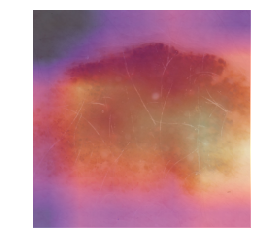